## Neural Network Disturbance 

* Import from EFPPO

In [1]:
import functools as ft
import pathlib

import ipdb
import jax
import jax.random as jr
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import typer
from loguru import logger

import efppo.run_config.f16
from efppo.task.f16 import F16GCASFloorCeil
from efppo.task.f16_safeguarded import MORELLI_BOUNDS, F16Safeguarded

from efppo.rl.collector import RolloutOutput, collect_single_mode,  CollectorState
from efppo.rl.efppo_inner import EFPPOInner
from efppo.rl.rootfind_policy import Rootfinder, RootfindPolicy
from efppo.task.plotter import Plotter
from efppo.utils.ckpt_utils import get_run_dir_from_ckpt_path, load_ckpt_ez
from efppo.utils.jax_utils import jax2np, jax_vmap, merge01
from efppo.utils.logging import set_logger_format
from efppo.utils.path_utils import mkdir

from gp_cbf.src.f16 import F16GCASFloorCeilDisturbed

import jax
import jax.numpy as jnp
from jax import random



2024-07-12 15:39:12.428892: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Define function

In [2]:
def generate_rollouts(task, alg, rootfind_pol, x0s = [],z0s = [], T = 512) -> RolloutOutput:
    # Roll out episode length
    rollout_T = T
 
    ## Collect trajectory
    collect_fn = ft.partial(
            collect_single_mode,
            task,
            get_pol=rootfind_pol,
            disc_gamma=alg.disc_gamma,
            z_min=alg.z_min,
            z_max=alg.z_max,
            rollout_T=rollout_T,
        )
        
    vmap_fn = jax.jit(jax_vmap(collect_fn, rep=1))
    bb_rollout: RolloutOutput = jax2np(vmap_fn(x0s, z0s)) 
    return bb_rollout

def plot_rollouts(plotter, bb_rollout, fig_name=None):
    ###############################3
    # Plot. 
    figsize = np.array([1, 1])
    fig, ax = plt.subplots(figsize=figsize, dpi=500)
    fig = plotter.plot_traj(bb_rollout.Tp1_state, multicolor=True, ax=ax)
    if fig_name is None:
        fig_name = 'fig.jpg' 
    fig_path = './' + fig_name
    fig.savefig(fig_path, bbox_inches="tight") 
    plt.rcParams.update({'xtick.labelsize': 2, "xtick.major.size": 1, 
                         'ytick.labelsize': 2, "ytick.major.size": 1,
                         'font.size': 2
                         })
    plt.show()
    plt.close(fig)

def get_initial_states(task, alg, num = 1):    
    # Plot configuration
    bb_X, bb_Y, bb_x0 = jax2np(task.grid_contour())
    b1, b2 = bb_X.shape
    bb_z0 = np.full((b1, b2), alg.z_max)    
    print(bb_x0.shape, bb_z0.shape)

    # Plot configuration
    ids = np.random.choice(b1 * b2, num, replace=False)
    idxs = list(map(lambda idx:  (int(idx/b2), idx % b2), ids))
    rows, cols = zip(*idxs)
    bb_x0 = bb_x0[rows, cols]
    bb_z0 = bb_z0[rows, cols]
    print(bb_x0.shape, bb_z0.shape)
    return bb_x0, bb_z0

# Define the MLP
def init_mlp_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes) - 1)
    for in_size, out_size, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight_key, bias_key = random.split(key)
        weights = random.normal(weight_key, (in_size, out_size))
        biases = random.normal(bias_key, (out_size,))
        params.append((weights, biases))
    return params

def mlp_predict(params, x):
    for weights, biases in params[:-1]:
        y = jnp.dot(x, weights) + biases
        x = jax.nn.sigmoid(y)
    final_weights, final_biases = params[-1]
    return 0.1 * jax.nn.sigmoid(jnp.dot(x, final_weights) + final_biases)


def normalization (weights, softplus_ci = jax.nn.softplus(1.)) :
    absrowsum = jnp.sum(jnp. abs(weights), axis=1)
    scale = jnp.minimum (1.0, softplus_ci/absrowsum)
    return weights * scale[:, None]
    
def l1_mlp_predict(params, x):
    for weights, biases in params[:-1]:
        y = jnp.dot(x, normalization(weights)) + biases
        x = jax.nn.sigmoid(y)
    final_weights, final_biases = params[-1]
    return 0.1 * jax.nn.sigmoid(jnp.dot(x, normalization(final_weights)) + final_biases)
 


* Load a trained policy

In [3]:
ckpt_path = pathlib.Path("/home/zwc662/Workspace/MIT-REALM/efppo/runs/F16GCASFloorCeil_inner/0001-run2/ckpts/09999999/default/")
run_dir = get_run_dir_from_ckpt_path(ckpt_path)

* Testing the undistrubed model

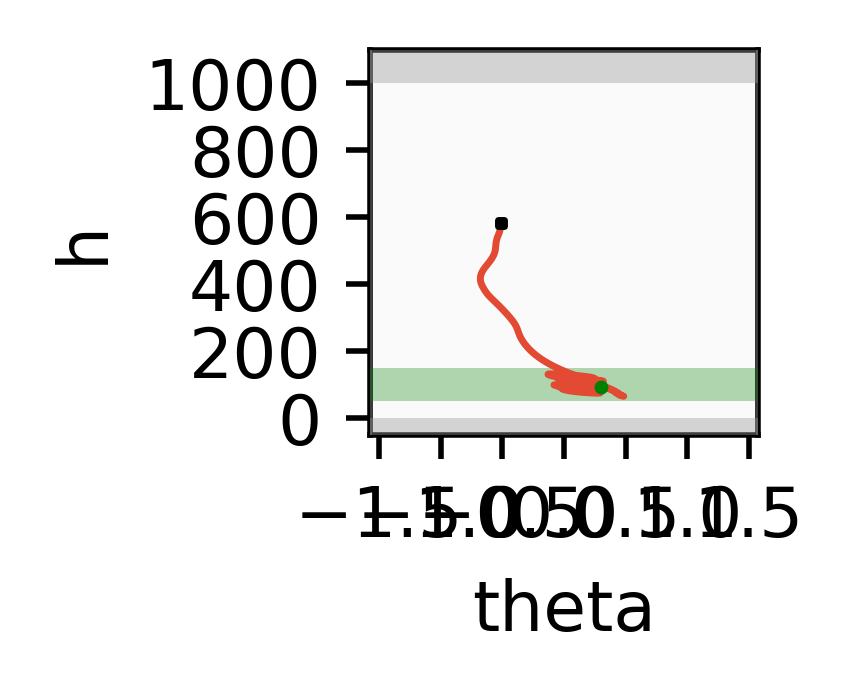

In [4]:
task = F16GCASFloorCeilDisturbed()
task.dt /= 2
plotter = Plotter(task)
    

alg_cfg, collect_cfg = efppo.run_config.f16.get()
alg: EFPPOInner = EFPPOInner.create(jr.PRNGKey(0), task, alg_cfg)

ckpt_dict = load_ckpt_ez(ckpt_path, {"alg": alg})
alg = ckpt_dict["alg"]

rootfind = Rootfinder(alg.Vh.apply, alg.z_min, alg.z_max, h_tgt=-0.70)
rootfind_pol = RootfindPolicy(alg.policy.apply, rootfind)

#x0s, z0s = get_initial_states(task, alg, num = 1)
x0s=jnp.array([[5.0208966e+02,  2.6170975e-02,  0.0000000e+00,  0.0000000e+00,
  -5.1428574e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
   0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  5.8095239e+02,
   7.6033545e+00,  2.4300486e-02,  0.0000000e+00,  0.0000000e+00,
   0.0000000e+00]])
z0s=jnp.array([2.5])

rollouts = generate_rollouts(task, alg, rootfind_pol, x0s, z0s)
plot_rollouts(plotter, bb_rollout=rollouts, fig_name='sim_trajs.jpg')

 

### Create a disturbed model

A time variant Gaussian noise disturbance is added to the $\theta$ state variable. The mean and std of the noise are proportional to the $\theta$ of current state $x_t$. 

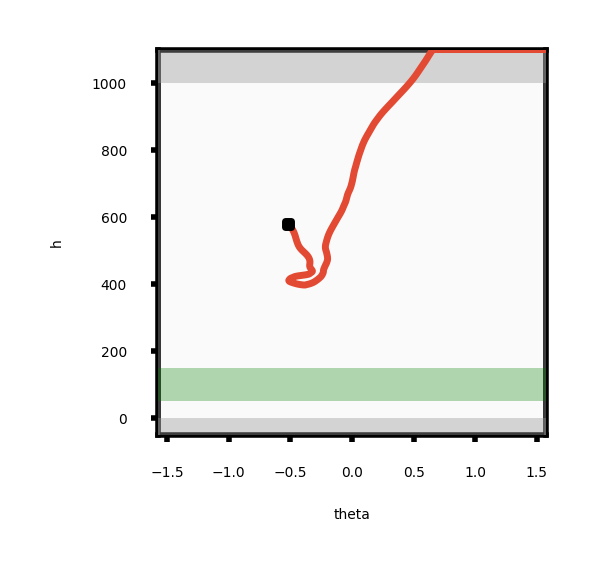

In [5]:
import flax.linen as nn
from efppo.networks.mlp import MLP
from efppo.networks.network_utils import ActLiteral, HidSizes, get_act_from_str, get_default_tx
from efppo.networks.train_state import TrainState
from efppo.networks.value_net import ConstrValueNet, CostValueNet
from efppo.utils.cfg_utils import Cfg

dist_task = F16GCASFloorCeilDisturbed()
dist_task.dt /= 2


# Define Vl network.
# Initialize parameters for a 3-layer MLP with input size 3, hidden layers of sizes 4 and 4, and output size 1
layer_sizes = [dist_task.nx, 16, 8, 2]
key = random.PRNGKey(0)
dist_params = init_mlp_params(layer_sizes, key)
 
# Get the output
def get_dist_state(state, *args, **kwargs):
    [theta_mean, theta_var] = l1_mlp_predict(dist_params, state) 
    state = state.at[F16Safeguarded.THETA].set(
        state[F16Safeguarded.THETA] + theta_mean) # + theta_var * np.random.normal())
    return state

dist_task.get_dist_state = get_dist_state


dist_rollouts = generate_rollouts(dist_task, alg, rootfind_pol, x0s, z0s)
plot_rollouts(plotter, bb_rollout=dist_rollouts, fig_name='dist_trajs.jpg')

* Simulate from every measured state for T=512 steps

(1, 513, 17)
(1, 513)


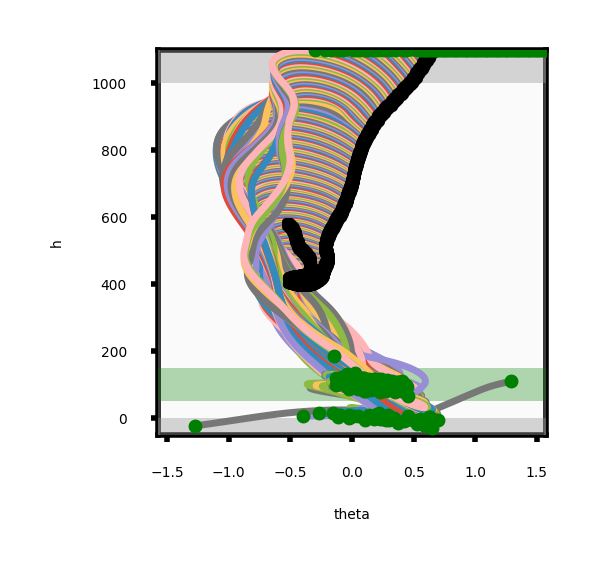

In [6]:
print(dist_rollouts.Tp1_state.shape)
print(dist_rollouts.Tp1_z.shape)
xms = dist_rollouts.Tp1_state.reshape(-1, 17)
zms = dist_rollouts.Tp1_z.reshape(-1)
bb_sims = generate_rollouts(task, alg, rootfind_pol, xms, zms, T = 512)
plot_rollouts(plotter, bb_rollout=bb_sims, fig_name='dist_sim_trajs.jpg') 

## Standard Adaptive Control

### Overview
Standard adaptive control is a control strategy that adjusts the controller parameters in real-time to cope with system uncertainties and variations.

### System Dynamics
Consider a system described by:
$$\dot{x}(t) = A x(t) + B u(t) + d(t)$$
where:
- $x(t)$ is the state vector.
- $u(t)$ is the control input.
- $d(t)$ represents disturbances.

### Adaptive Control Law
The control input $u(t)$ is designed to minimize the tracking error $e(t) = x_d(t) - x(t)$, where $x_d(t)$ is the desired state trajectory.

### Parameter Update Law
Use linear model $\theta^T \phi(x(t))$ to approximate $e(t)$. 
The update law is typically defined using a Lyapunov function:
$$\dot{\hat{\theta}} = -\Gamma \phi(x(t), u(t)) e(t)$$
where:
- $\hat{\theta}$ is the vector of estimated parameters.
- $\Gamma$ is the adaptation gain matrix.
- $\phi(x(t), u(t))$ is the regressor vector.

**Related to Linear regression??** 

## Learning Neural Network Disturbance

### Dataset

Create a dataset of disturbance errors.
From each step $t$ to the next step $t+1$, the measured states are $x_t$ and $x_{t+1}$. 
However, the simulated next state is $\hat{x}_{t+1}$.
Now build a dataset $D=\{x_t, y_t = \hat{x}_{t+1} - \hat{x}_{t+1}\}$

In [7]:
# Simulated states xs shape is (nx, T, dx) <= nx: number of measured states, T: simulation length: dx: dim of each state 
# Get 1st simulated step state for each measured states. Ignore the last state because there is no next state
xs = bb_sims.Tp1_state[:-1, 1, :]
print(xs.dtype, xs.shape) 
# Measured states xms shape is (num_traj, T, dx) <= num_traj: num of trajectories, T: simulation length, dx: dim of each state
# Flatten the trajectories. Ignore the last state because there is no next state
xms = dist_rollouts.Tp1_state.reshape(-1, 17)
#print(xms.dtype, xms.shape) 

cur_xms = xms[:-1]
nxt_xms = xms[1:,:]

assert (bb_sims.Tp1_state[:, 0] == xms[:]).all()

assert xs.shape[0] == cur_xms.shape[0] == nxt_xms.shape[0]

X = cur_xms[:]
y = nxt_xms[:,F16Safeguarded.THETA:F16Safeguarded.THETA+1] - xs[:, F16Safeguarded.THETA: F16Safeguarded.THETA+1]
 
print(X.dtype, X.shape)
print(y.dtype, y.shape)
 

float32 (512, 17)
float32 (512, 17)
float32 (512, 1)


### Training

* Use the same neural network structure as the ground true dynamical model to simulate the error

In [8]:
# Define Vl network.
# Initialize parameters for a 3-layer MLP with input size 3, hidden layers of sizes 4 and 4, and output size 1
layer_sizes = [dist_task.nx, 32, 16, 1]
 
from jax import grad

nn_key = random.PRNGKey(10)
params = init_mlp_params(layer_sizes, nn_key)

# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = jax_vmap(l1_mlp_predict, in_axes=(None, 0))

def loss(params, x, y):
    pred = batched_predict(params, x)
    err = jnp.mean((pred[:,0] - y) ** 2)
    return err
 
@jax.jit
def update(step, params, x, y):
    err = loss(params, x, y)
    grads = grad(loss)(params, x, y)
    return {
        'params': [(w - step * dw, b - step * db)
          for (w, b), (dw, db) in zip(params, grads)], 
          'mse': err, 
          'grads': grads
    }
 
num_epochs = 500000
step = 0.01
for epoch in range(num_epochs):
    info = update(step, params, X, y)
    params = info['params']
    #print(info) # grads)
    if epoch % 100 == 0:
        train_loss = loss(params, X, y) 
        print(f'Epoch {epoch}, Train Loss: {train_loss}')
        

Epoch 0, Train Loss: 0.00020786377717740834
Epoch 100, Train Loss: 0.00020786374807357788
Epoch 200, Train Loss: 0.00020786368986591697
Epoch 300, Train Loss: 0.00020786367531400174
Epoch 400, Train Loss: 0.0002078636025544256
Epoch 500, Train Loss: 0.0002078635588986799
Epoch 600, Train Loss: 0.00020786352979484946
Epoch 700, Train Loss: 0.00020786348613910377
Epoch 800, Train Loss: 0.0002078634570352733
Epoch 900, Train Loss: 0.0002078633988276124
Epoch 1000, Train Loss: 0.00020786335517186671
Epoch 1100, Train Loss: 0.00020786331151612103
Epoch 1200, Train Loss: 0.00020786326786037534
Epoch 1300, Train Loss: 0.0002078632387565449
Epoch 1400, Train Loss: 0.00020786316599696875
Epoch 1500, Train Loss: 0.00020786315144505352
Epoch 1600, Train Loss: 0.00020786310778930783
Epoch 1700, Train Loss: 0.00020786304958164692
Epoch 1800, Train Loss: 0.00020786302047781646
Epoch 1900, Train Loss: 0.00020786296227015555
Epoch 2000, Train Loss: 0.00020786291861440986
Epoch 2100, Train Loss: 0.0002

### Generate test data

(1, 513, 17)
(1, 513)


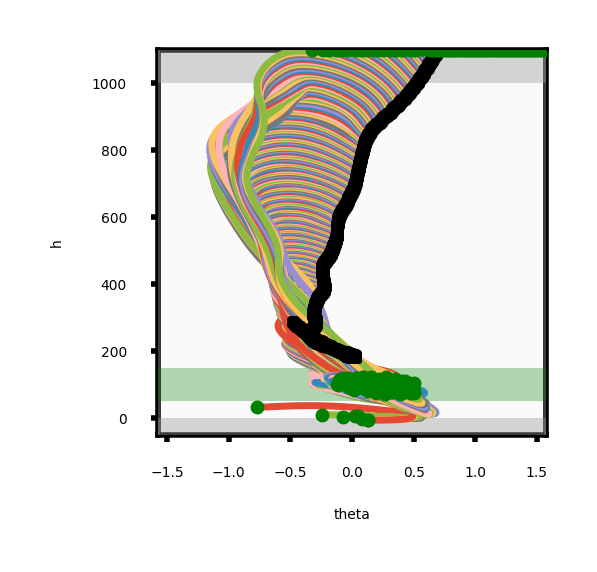

In [9]:
#x0s_test, z0s_test = get_initial_states(dist_task, alg, num = 1)
x0s_test = jnp.array([[ 5.0208966e+02,  2.6170975e-02,  0.0000000e+00,  0.0000000e+00,
  -4.7619048e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
   0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.8888889e+02,
   7.6033545e+00,  2.4300486e-02,  0.0000000e+00,  0.0000000e+00,
   0.0000000e+00]])
z0s_test = jnp.array([2.5])

dist_rollouts_test = generate_rollouts(dist_task, alg, rootfind_pol, x0s_test, z0s_test)
print(dist_rollouts_test.Tp1_state.shape)
print(dist_rollouts_test.Tp1_z.shape)
xms_test = dist_rollouts_test.Tp1_state.reshape(-1, 17)
zms_test = dist_rollouts_test.Tp1_z.reshape(-1)
bb_sims_test = generate_rollouts(task, alg, rootfind_pol, xms_test, zms_test, T = 512)
plot_rollouts(plotter, bb_rollout=bb_sims_test, fig_name='dist_sim_trajs_test.jpg')


### Load the neural network into the F16 model

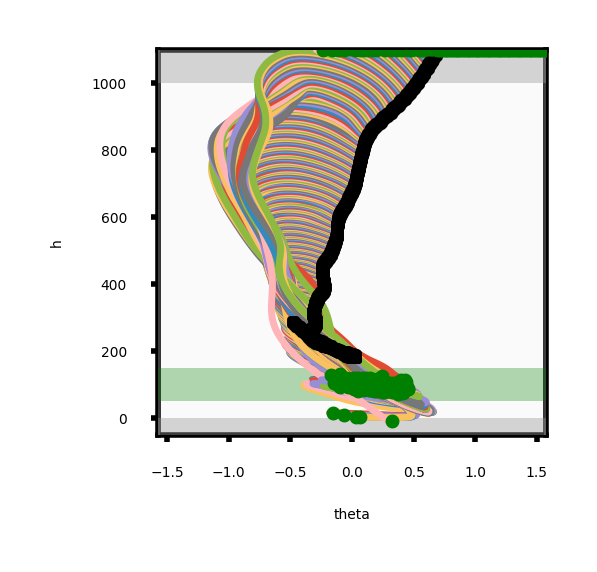

In [10]:
nn_task = F16GCASFloorCeilDisturbed()
nn_task.dt /= 2
# Get the output
def nn_dist_state(state, *args, **kwargs):
    err = l1_mlp_predict(params, state)
    state = state.at[F16Safeguarded.THETA].set(
        state[F16Safeguarded.THETA] + err[0]
    )
    return state
nn_task.get_dist_state = nn_dist_state

nn_sims_test = generate_rollouts(nn_task, alg, rootfind_pol, xms_test, zms_test, T = 512)
plot_rollouts(plotter, bb_rollout=nn_sims_test, fig_name='nn_sim_trajs_test.jpg')


## L1 Adaptive Control with Matched and Unmatched Disturbances 


### Overview
[L1 adaptive control](https://arxiv.org/pdf/2112.01953) is a robust adaptive control method designed to ensure system stability and performance in the presence of uncertainties and disturbances.

### System Dynamics
The system dynamics can be represented as:
$$\dot{x}(t) = f(x(t)) + g(x(t))u(t) + \sigma(x(t), u(t))$$
where disturbance $\sigma(x(t))$ represented as $\sigma(x(t))= [g(x(t)), g^\bot(x(t))]\cdot[\hat{\sigma}_m(x(t)), \hat{\sigma}_{um}(x(t))]$:
- $g^\bot(x(t))$: The orthogonal compliment of $g(x(t))$
- $\hat{\sigma}_m(x(t))$: Matched disturbance
- $\hat{\sigma}_{um}(x(t))$: Unmatched disturbance
 
### Control Law
  $$u(t) = u_n(t) - \hat{\sigma}_m(x(t))$$
 
 

* Test on dist_rollout

In [11]:
## Get g(x(t)) from the gradient of x(t+1) w.r.t u(t)

from jax import jacfwd, jacrev


 
## Get disturbance at each time step in dist_rollouts
dists = jnp.zeros_like(xms[1:])
dists = dists.at[:, F16Safeguarded.THETA].set(y[:, 0])

## Get g(x(t)) as the gradient of x(t+1) w.r.t u(t) 
ums = dist_rollouts.T_control[0]

vmap_grad_fn = jax.jit(jax_vmap(task.linearization, rep=1))
info = jax2np(vmap_grad_fn(xms[:-1], ums)) 
g_xms = info['control']
print(g_xms.shape)

## Get orthogonal compliment of g(x(t))'set
def g_bot_fn(g):
    q, r = jax.scipy.linalg.qr(g, mode='full')
    # Extract the orthogonal complement
    g_bot = q[:, g.shape[1]:]
    return g_bot

vmap_g_bot_fn = jax.jit(jax_vmap(g_bot_fn, rep=1))
g_bot = jax2np(vmap_g_bot_fn(g_xms))
print(g_bot.shape)



(512, 17, 4)


RuntimeError: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

### Implement L1-adaptive-control

* Re-build control law into `task.step` function

In [ ]:
import types
from jax.numpy.fft import fft, ifft, fftfreq

ada_task = F16GCASFloorCeilDisturbed()

def get_dist_state(self, nxt_state, control):
    nxt_dist_state = dist_task.get_dist_state(nxt_state) 
    
    # Update Z dynamics.
    l = self.l(nxt_dist_state, control)
    z_new = (self.l1_control_info['z'] - l) / alg.disc_gamma
    z_new = jnp.clip(z_new, alg.z_min, alg.z_max) 

    sigma = nxt_dist_state - nxt_state

    nxt_obs_pol = self.get_obs(nxt_dist_state)
    nxt_a_pol = rootfind_pol(nxt_obs_pol, z_new)
    nxt_control = nxt_a_pol.mode()
    
    info = self.linearization(nxt_dist_state, nxt_control)
    g = info['control']
    #jax.debug.print("g = {}", g)
    g_bot = g_bot_fn(g)
    #jax.debug.print("g_bot = {}", g_bot)
    g_g_bot = jnp.hstack([g, g_bot])
    #jax.debug.print("g_g_bot = {}", g_g_bot)
    sigma_m = jnp.dot(jnp.linalg.pinv(g_g_bot), sigma)[:4]
    #jax.debug.print("sigma_m = {}", sigma_m)
    
    if self.l1_control_info['hist_controls'] is None:
        self.l1_control_info['hist_controls'] = sigma_m
    else:
        self.l1_control_info['hist_controls'] = jnp.stack((
            self.l1_control_info['hist_controls'],
            sigma_m
        )
        ) 
    jax.debug.print("self.l1_control_info['hist_controls'].shape = {}", self.l1_control_info['hist_controls'].shape)
    
    lap = fft(self.l1_control_info['hist_controls']) * self.dt
    freqs = fftfreq(len(self.l1_control_info['hist_controls']), self.dt)
    filtered = lap * (jnp.abs(freqs) <= 100)
    self.l1_control_info['control'] = (ifft(filtered) / self.dt).real
    jax.debug.print("self.l1_control_info['control'] = {}", self.l1_control_info['control']) 
    return nxt_dist_state

ada_task.get_dist_state = types.MethodType(get_dist_state, ada_task)

ada_rollouts = generate_rollouts(ada_task, alg, rootfind_pol, x0s_test, z0s_test)
plot_rollouts(plotter, bb_rollout=ada_rollouts, fig_name='ada_trajs.jpg') 

### Comparison: No L1 adaptive control

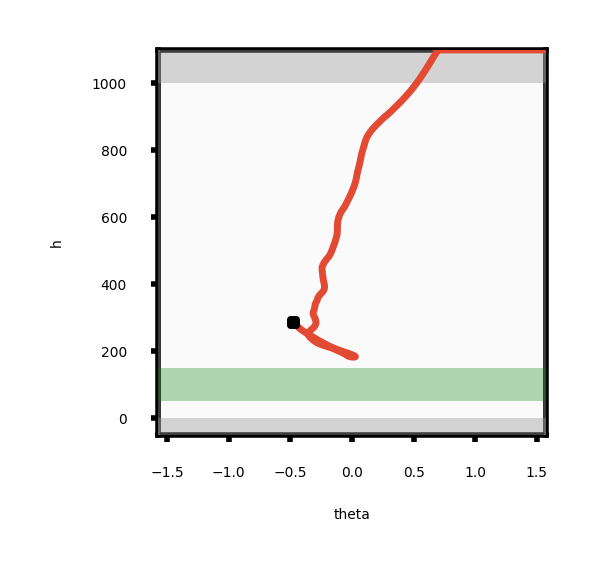

In [ ]:
dist_rollouts_test = generate_rollouts(dist_task, alg, rootfind_pol, x0s_test, z0s_test)
plot_rollouts(plotter, bb_rollout=dist_rollouts_test, fig_name='dist_trajs_test.jpg') 